In [1]:
import os
# Set cuda device to use
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

# do not prealocate memory
os.environ["XLA_PYTHON_CLIENT_PREALLOCATE"] = "false"
os.environ["XLA_PYTHON_CLIENT_ALLOCATOR"] = "platform"

In [2]:
import numpy as np
import jax.numpy as jnp
import matplotlib.pyplot as plt
import seaborn as sns

from jax import vmap
from jaxtyping import Array
from adsprites import DSprites

In [3]:
task = DSprites(batch_size=64, seed=101)
task.imgs.dtype

dtype('float16')

In [4]:
state = jnp.array([0, 0, 0, 0, 0, 0])
indx = task.state_to_index(state)
test_img = task.imgs[indx][..., 10:22, 10:22]

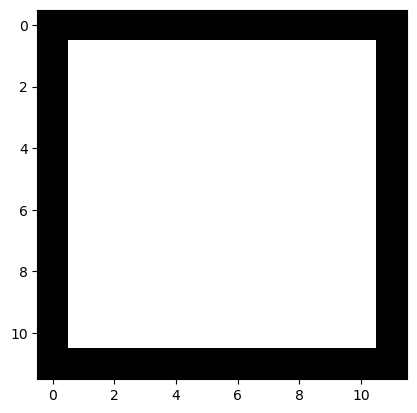

In [5]:
plt.imshow(test_img.transpose(1, 2, 0), cmap='Greys_r')

In [6]:
from equinox import Module
from jax.scipy.ndimage import map_coordinates

# https://kevinzakka.github.io/2017/01/10/stn-part1/
# https://kevinzakka.github.io/2017/01/18/stn-part2/

class SpatialTransformerNetwork(Module):
    height: int 
    width: int
    sampling_grid: Array
    
    def __init__(self, height, width):
        self.height = height
        self.width = width

        # create normalized 2D grid
        x = jnp.linspace(-1, 1, width)
        y = jnp.linspace(-1, 1, height)
        x_t, y_t = jnp.meshgrid(x, y)

        # reshape to (xt, yt, 1)
        ones = jnp.ones(np.prod(x_t.shape))
        self.sampling_grid = jnp.vstack([x_t.flatten(), y_t.flatten(), ones])


    def bilinear_sampler(self, input_img, x, y):
        """
        Performs bilinear sampling of the input images according to the
        normalized coordinates provided by the sampling grid. Note that
        the sampling is done identically for each channel of the input.

        To test if the function works properly, output image should be
        identical to input image when theta is initialized to identity
        transform.

        Input
        -----
        - input_imgs: batch of images in (B, H, W, C) layout.
        - grid: x, y which is the output of affine_grid_generator.

        Returns
        -------
        - interpolated images according to grids. Same size as grid.
        """
        # grab dimensions
        C, H, W = input_img.shape

        max_y = (H - 1)
        max_x = (W - 1)

        # rescale x and y to [0, W-1/H-1]
        x = (x + 1.) * max_x * 0.5
        y = (y + 1.) * max_y * 0.5

        mc = lambda img: map_coordinates(img, [x, y], order=1)
        out = vmap(mc)(input_img)

        return out

    def __call__(self, img, θ):

        M = θ.reshape(2, 3)
        batch_grids = (M @ self.sampling_grid).reshape(2, self.height, self.width)
        x, y = batch_grids[0], batch_grids[1]

        return self.bilinear_sampler(img, x, y)

stn = SpatialTransformerNetwork(64, 64)

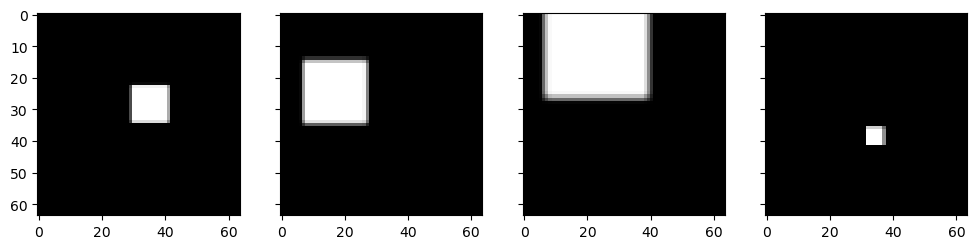

In [7]:
fig, axes = plt.subplots(1, 4, figsize=(12, 5), sharex=True, sharey=True)

for ax in axes:
    x = np.random.normal(size=2)
    s = 1 + 10 * np.random.uniform()
    θ = jnp.array([s, 0, x[0], 0, s, x[1]])
    out_img = stn(test_img, θ)
    ax.imshow(out_img.transpose(1, 2, 0), cmap='Greys_r')

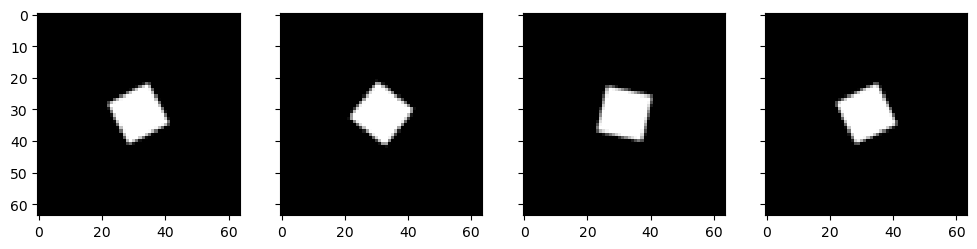

In [8]:
fig, axes = plt.subplots(1, 4, figsize=(12, 5), sharex=True, sharey=True)

for ax in axes:
    x = np.array([0, 0]) # np.random.normal(size=2)
    s = 2 * np.random.uniform() - 1
    cos = 4 * s
    sin = 4 * jnp.sqrt(1 - s ** 2)
    θ = jnp.array([cos, - sin, x[0], sin, cos, x[1]])
    out_img = stn(test_img, θ)
    ax.imshow(out_img.transpose(1, 2, 0), cmap='Greys_r')

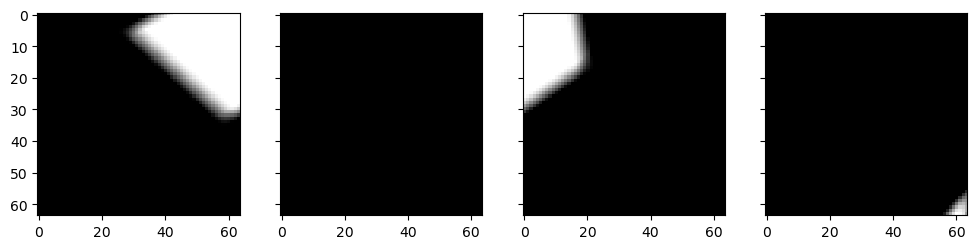

In [9]:
fig, axes = plt.subplots(1, 4, figsize=(12, 5), sharex=True, sharey=True)

for ax in axes:
    θ = np.random.normal(size=6)
    out_img = stn(test_img, θ)
    ax.imshow(out_img.transpose(1, 2, 0), cmap='Greys_r')

In [10]:
import equinox.nn as enn
from equinox import filter_jit, Module
from typing import List, Callable
import jax.random as jr
from jax import vmap, nn

class Encoder(Module):
    layers: List[enn.Linear]
    act = Callable

    def __init__(self, z_dim, hidden_dim, input_dim, activation=nn.relu, *, key):

        self.layers = []
        self.act = activation
        
        key, _key = jr.split(key)
        self.layers.append(enn.Linear(input_dim, hidden_dim, key=_key))

        key, _key = jr.split(key)
        self.layers.append(enn.Linear(hidden_dim, z_dim, key=_key))

        key, _key = jr.split(key)
        self.layers.append(enn.Linear(hidden_dim, z_dim, key=_key))

    def __call__(self, x):

        z = self.layers[0](x.reshape(-1))
        z = self.act(z)

        loc = self.layers[-1](z)
        scale = jnp.exp(self.layers[-2])(z)

        return loc, scale
    
class Decoder(Module):
    layers: List[enn.Linear]
    act = Callable

    def __init__(self, z_dim, hidden_dim, output_dim, activation=nn.relu, *, key):

        self.layers = []
        self.act = activation

        key, _key = jr.split(key)
        self.layers.append(enn.Linear(z_dim, hidden_dim, key=_key))

        key, _key = jr.split(key)
        self.layers.append(enn.Linear(hidden_dim, output_dim, key=_key))

    def __call__(self, z):

        h = self.layers[0](x)
        h = self.act(h)

        θ = self.layers[1](h)

        return θ

In [12]:
import equinox as eqx
import numpyro
import jax.tree_util as jtu

def init_fn(rng_key, shape, radius=1.):
    return jr.uniform(rng_key, shape=shape, minval=-radius, maxval=radius)

def get_linear_layers(layer):
    is_linear = lambda x: isinstance(x, eqx.nn.Linear) or isinstance(x, eqx.nn.Conv) or isinstance(x, eqx.nn.LayerNorm)
    return [x for x in jtu.tree_leaves(layer, is_leaf=is_linear) if is_linear(x)]

def register_nnet_params(name, nnet, layers):
    new_layers = []
    for l, layer in enumerate(layers):
        weight = layer.weight
        bias = layer.bias
        shape = weight.reshape(weight.shape[0], -1).shape
        if bias is not None:
            shape = (shape[0], shape[1] + 1)
        
        params = numpyro.param(f'{name}.layer{l}.params', lambda key: init_fn(key, shape))

        if bias is None:
            weight = params.reshape(weight.shape)
        else:
            assert bias.shape == weight.shape[:-1]
            weight = params[..., :-1].reshape(weight.shape)
            bias = params[..., -1]
        
        layer = eqx.tree_at(lambda x: (x.weight, x.bias), layer, (weight, bias))
        new_layers.append(layer)
    
    nnet = eqx.tree_at(get_linear_layers, nnet, new_layers)

    return nnet

In [147]:
import numpyro.distributions as dist
from numpyro.infer import Predictive, SVI, TraceGraph_ELBO
from numpyro.handlers import seed

In [144]:
D = 10
input_dim = np.prod(task.imgs.shape[1:])
key = jr.PRNGKey(0)
key, _key = jr.split(key)
decoder = Decoder(D, 100, 6, key=_key)

key, _key = jr.split(key)
encoder = Encoder(D, 2024, input_dim)

def prior(stn, smpl_img, D):
    
    reg_decoder = register_nnet_params(decoder)

    # Sample object pose.
    z = numpyro.sample('z',
                          dist.Normal(jnp.zeros(D), jnp.ones(D)).to_event(1)
                        )
    θ = vmap(reg_decoder)(z)    
    # Position/scale object within larger image.
    y = vmap(stn, in_axes=(None, 0))(smpl_img, θ)
    return y

def model(stn, smpl_img, D, batch_size=32, data=None):
    N = batch_size if data is None else len(data)
    with numpyro.plate('batch', N, subsample_size=batch_size):
      obs = numpyro.subsample(data, event_dim=3) if data is not None else None
      loc = prior(stn, smpl_img, D)
      scale = 0.1
      numpyro.sample('obs', dist.Normal(loc, scale).to_event(3), obs=obs)

def guide(stn, smpl_img, D, batch_size=32, data=None):
   reg_encoder = register_nnet_params(encoder)
   assert data is not None
   N = len(data)
   with numpyro.plate('batch', N, subsample_size=batch_size):
      obs = numpyro.subsample(data, event_dim=3)
      loc, scale = vmap(reg_encoder)(obs)
      numpyro.sample('z', 
                     dist.Normal(loc, scale).to_event(1)
                     )

In [145]:
with seed(rng_seed=0):
    model(stn, test_img, 10)

In [148]:
pred = Predictive(model, num_samples=1)

samples = pred(jr.PRNGKey(0), stn, test_img, 10)

In [149]:
samples['obs'].shape

(1, 32, 1, 64, 64)